**Notebook used to make particle-level evaluation plots**

- Stacked histograms
- Particle $p_T$, $\eta$, $\phi$
- Efficiency and Fake rate

In [1]:
import os, sys, glob
import pickle as pkl
import uproot
import awkward as ak
import vector
import numpy as np
vector.register_awkward()

import boost_histogram as bh
import numba
import mplhep
import mplhep as hep
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import tqdm

mplhep.set_style(mplhep.styles.CMS)

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/1844221431.py:20: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [2]:
sys.path += ["../../mlpf/plotting//"]
from plot_utils import EVALUATION_DATASET_NAMES, experiment_label
from plot_utils import SAMPLE_LABEL_CMS, pid_to_text, EXPERIMENT_LABELS

In [3]:
pid_to_text[22] = "photon"

In [4]:
EVALUATION_DATASET_NAMES["cms_pf_qcd_nopu"] = "QCD multijet, no PU"

In [41]:
def sample_label(ax, sample, additional_text="", x=0.05, y=0.95, fontsize=35, color="black"):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, fontsize=fontsize, color=color)

def cms_label(ax):
    hep.cms.label(llabel='Simulation', rlabel='Run 3 (13.6 TeV)', ax=ax)

In [6]:
@numba.njit
def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_particles(eta1, eta2, phi1, phi2, deltaR_cut):
    nev = len(eta1)
    ptcl_inds_1_ev = []
    ptcl_inds_2_ev = []
    best_drs_ev = []
    for iev in range(nev):
        ptcl_inds_1 = []
        ptcl_inds_2 = []
        best_drs = []

        # loop over the first collection
        pfs_used = np.zeros(len(eta2[iev]))
        for ip1 in range(len(eta1[iev])):
            # compute deltaR from this particle to all particles in the other collection
            drs = 999*np.ones(len(eta2[iev]), dtype=np.float64)

            # loop over the second collection
            for ip2 in range(len(eta2[iev])):
                if pfs_used[ip2]==1:
                    continue
                _eta1 = eta1[iev][ip1]
                _eta2 = eta2[iev][ip2]
                _phi1 = phi1[iev][ip1]
                _phi2 = phi2[iev][ip2]

                dr = deltar(_eta1, _phi1, _eta2, _phi2)
                drs[ip2] = dr

            if len(drs) > 0:
                # find closest match to this particle
                min_idx_dr = np.argmin(drs)

                # has to be closer than the deltaR_cut
                if drs[min_idx_dr] < deltaR_cut:
                    ptcl_inds_1.append(ip1)
                    ptcl_inds_2.append(min_idx_dr)
                    best_drs.append(drs[min_idx_dr])
                    pfs_used[min_idx_dr] = 1
                
        ptcl_inds_1_ev.append(ptcl_inds_1)
        ptcl_inds_2_ev.append(ptcl_inds_2)
        best_drs_ev.append(best_drs)
    return ptcl_inds_1_ev, ptcl_inds_2_ev, best_drs_ev

def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values
    
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1

def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

In [7]:
######### To remap GEN pids

import particle
from particle import Particle
from particle import PDGID # https://github.com/scikit-hep/particle

import numba
from numba import njit
from numba.typed import Dict
from numba.core import types

@numba.njit
def get_charge_numba(pids, pid_to_charge_numbadict):
    ret = np.zeros(len(pids))
    for i in range(len(pids)):
        ret[i] = pid_to_charge_numbadict[pids[i]]
    return ret
    
def get_charge_array(pdgids):
    pids_uniq = np.unique(pdgids)
    pid_to_charge = {
        pid: Particle.from_pdgid(pid).charge for pid in pids_uniq
    }
    
    pid_to_charge_numbadict = Dict.empty(key_type=types.int64, value_type=types.float64)
    for pid, c in pid_to_charge.items():
        pid_to_charge_numbadict[pid] = c

    ret = get_charge_numba(pdgids, pid_to_charge_numbadict)
    return ak.Array(ret)

def remap_pid_gen(data):
    """
    GenCands have all sorts of PID so must remap
    """
    pid = np.abs(np.asarray(ak.flatten(data["GenCands_pdgId"])))
    
    pa = ak.flatten(np.abs(data["GenCands_pdgId"]))
    pc = np.abs(get_charge_array(ak.flatten(data["GenCands_pdgId"])))

    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenCands_pid"] = ak.unflatten(pid, ak.count(data["GenCands_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

In [8]:
def compute_relative_isolation(vecs, dr=0.4):
    """
    Compute relative isolation per particle:
    RelIso = sum_pt_neighbors_within_dR / pt_particle

    Parameters:
    - vecs: awkward array with Momentum4D behavior
    - dr: deltaR threshold to consider neighbors

    Returns:
    - RelIso: awkward array of relative isolation values, same shape as vecs
    """
    # Pair each particle with all others in the same event
    pairs = ak.cartesian([vecs, vecs], axis=1, nested=True)
    cand, neighbor = ak.unzip(pairs)

    # Compute deltaR between candidate and neighbors
    delta_r = cand.deltaR(neighbor)

    # Mask out self-comparisons
    is_not_self = delta_r > 0
    is_neighbor = (delta_r < dr) & is_not_self

    # Sum neighbor pt within cone if pdgid is ch.had/n.had/photon
    msk = is_neighbor & ( (neighbor.pid==211) | (neighbor.pid==130) | (neighbor.pid==22) )
    neighbor_pt = ak.where(msk, neighbor.pt, 0)    
    sum_neighbor_pt = ak.sum(neighbor_pt, axis=-1)

    # Candidate pt (same shape as sum_neighbor_pt)
    cand_pt = cand.pt[:, :, 0]  # broadcasted first particle in each pair row

    # Compute isolation
    RelIso = sum_neighbor_pt / cand_pt

    return RelIso

In [9]:
# PDG IDs of neutrinos
vELE_PDGID = 12
vMU_PDGID  = 14
vTAU_PDGID = 16

def fix_ak(arr):
    # replace None with empty list
    return ak.Array([x if x is not None else [] for x in arr])

def process_file(fn):
    # Load events
    with open(fn, "rb") as f:
        events = ak.Array(pkl.load(f))
    gen = events["packedGenParticles"]
    pf  = events["packedPFCandidates"]

    # Compute masks
    status = gen["status"]
    pdgId  = gen["pdgId"]
    
    msk_status = (status == 1)
    msk_nu     = (abs(pdgId) == vELE_PDGID) | \
                 (abs(pdgId) == vMU_PDGID)  | \
                 (abs(pdgId) == vTAU_PDGID)
    
    msk = msk_status & ~msk_nu

    # Slice and zip
    sliced = {
        "GenCands_pt":    gen.pt[msk],
        "GenCands_eta":   gen.eta[msk],
        "GenCands_phi":   gen.phi[msk],
        "GenCands_energy":   gen.energy[msk],
        "GenCands_pdgId": gen.pdgId[msk],
        "PFCands_pt":     pf.pt,
        "PFCands_eta":    pf.eta,
        "PFCands_phi":    pf.phi,
        "PFCands_energy":   pf.energy,
        "PFCands_pdgId":  pf.pdgId,
    }
    
    remap_pid_gen(sliced)

#     get rel iso
    gen_vecs = ak.zip(
        {
            "pt": sliced["GenCands_pt"],
            "eta": sliced["GenCands_eta"],
            "phi": sliced["GenCands_phi"],
            "energy": sliced["GenCands_energy"],
            "pid": sliced["GenCands_pid"],
        },
        with_name="Momentum4D",
    )
#     sliced["GenCands_reliso03"] = compute_relative_isolation(gen_vecs, dr=0.3)
#     sliced["GenCands_reliso05"] = compute_relative_isolation(gen_vecs, dr=0.5)

    pf_vecs = ak.zip(
        {
            "pt": sliced["PFCands_pt"],
            "eta": sliced["PFCands_eta"], 
            "phi": sliced["PFCands_phi"], 
            "energy": sliced["PFCands_energy"], 
            "pid": sliced["PFCands_pid"],
        },
        with_name="Momentum4D",
    )   
#     sliced["PFCands_reliso03"] = compute_relative_isolation(pf_vecs, dr=0.3)
#     sliced["PFCands_reliso05"] = compute_relative_isolation(pf_vecs, dr=0.5)
    
    return ak.zip(sliced, depth_limit=1)

from concurrent.futures import ThreadPoolExecutor
def load_multiprocess(files, max_workers=None):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm.tqdm(executor.map(process_file, files), total=len(files)))
    successful_results = [r for r in results if r is not None]

    return ak.concatenate(successful_results)

def load_singleprocess(files):
    results = []
    for i, fn in enumerate(tqdm.tqdm(files)):
        try:
            ret = process_file(fn)
            results.append(ret)
        except Exception as e:
            print("could not process " + fn)
    return ak.concatenate(results)

In [10]:
dataset = "cms"

save_as = {
    "cms_pf_qcd_nopu": "QCD_noPU_13p6",
    "cms_pf_ttbar_nopu": "TTbar_noPU_13p6",
}

sample = "cms_pf_ttbar_nopu"
# sample = "cms_pf_qcd_nopu"

In [11]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/

QCD_noPU_13p6_mlpfpu   TTbar_noPU_13p6_mlpfpu
QCD_noPU_13p6_pf       TTbar_noPU_13p6_pf


In [12]:
path_mlpf = f"../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/{save_as[sample]}_mlpfpu/step3_MINI_*.pkl"
path_pf = f"../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/{save_as[sample]}_pf/step3_MINI_*.pkl"

files_to_skip = []
# mlpf
files = glob.glob(path_mlpf)
# files = files[:1000]
# data_mlpf =  load_multiprocess([fn for fn in files], 16)
data_mlpf =  load_singleprocess([fn for fn in files])

# pf
files = glob.glob(path_pf)
# files = files[:1000]
# data_pf =  load_multiprocess([fn for fn in files], 16)
data_pf =  load_singleprocess([fn for fn in files])

  0%|                                                  | 0/2050 [00:00<?, ?it/s]/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)
100%|███████████████████████████████████████| 2050/2050 [02:34<00:00, 13.31it/s]


In [13]:
# def remap_pid_mlpf(data):
#     """
#     MLPF reconstructs...
#     """
#     # define eta cut and pid values
#     eta_cut = 2.4
#     old_pid_to_new = {
#         22: 1,
#         130: 2,
#         211: 2,        
#     }

#     # original arrays
#     eta = data["PFCands_eta"]
#     pid = data["PFCands_pid"]

#     # start with the original pid array
#     new_pid = pid

#     # apply remapping
#     for old_pid, new_pid_val in old_pid_to_new.items():
#         mask = (abs(eta) > eta_cut) & (pid == old_pid)
#         new_pid = ak.where(mask, new_pid_val, new_pid)

#     # now new_pid is your remapped array
#     # you can either use it directly or attach it as a new field
#     data["PFCands_pid"] = new_pid
    
# remap_pid_mlpf(data_mlpf)

# Plot configs

In [33]:
colors_CMS_recommendation = {
    "blue":   "#5790FC",  # (87, 144, 252)
    "orange": "#F89C20",  # (248, 156, 32)
    "red":    "#E42536",  # (228, 37, 54)
    "purple": "#964A8B",  # (150, 74, 139)
    "gray":   "#9C9CA1",  # (156, 156, 161)
    "violet": "#7A21DD",  # (122, 33, 221)
}

color_code = {
    "Gen": "#9C9CA1",  # Gray (156, 156, 161)
    "PF":   "#5790FC",  # blue (87, 144, 252)
    "MLPF": "#E42536",  # red (228, 37, 54)
    "Target": "#964A8B",  # purple (150, 74, 139)
}

bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(1,500,41),
        130: np.linspace(1,200,41),
        22: np.linspace(1,200,41),
        11: np.linspace(1,50,21),
        13: np.linspace(1,50,21),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(1,100,31),
        130: np.linspace(1,40,31),
        22: np.linspace(1,40,31),
        11: np.linspace(1,100,31),
        13: np.linspace(1,100,31),
    },  
}

bins_eta = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-2.4,2.4,41),
        130: np.linspace(-2.4,2.4,41),
        22: np.linspace(-2.4,2.4,41),
        11: np.linspace(-2.4,2.4,41),
        13: np.linspace(-2.4,2.4,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-2.4,2.4,41),
        130: np.linspace(-2.4,2.4,41),
        22: np.linspace(-2.4,2.4,41),
        11: np.linspace(-2.4,2.4,41),
        13: np.linspace(-2.4,2.4,41),
    },
}

bins_phi = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,41),
        13: np.linspace(-3,3,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,21),
        13: np.linspace(-3,3,21),
    },  
}

marker_style = {
    'PF': 'x',
    'MLPF': 'o',
}
linestyle = {
    'Gen': '--',
    'PF': ':',
    'MLPF': '-',
}

col_pid = {
    211: "tab:blue",
    130: "tab:orange",
    22: "tab:red",
    11: "tab:green",
    13: "tab:pink", 
    1: "tab:purple",
    2: "tab:brown",
}

In [15]:
os.makedirs(f"./plots/{save_as[sample]}/particle_pt_dist", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eta_dist", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_phi_dist", exist_ok=True)

os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d", exist_ok=True)

os.makedirs(f"./plots/{save_as[sample]}/particle_ptres", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_dR_circles", exist_ok=True)

os.makedirs(f"./plots/{save_as[sample]}/lepisolation", exist_ok=True)

# Stacked hist (paper plot, Figure 4)

## pT (Figure 4a)

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/3507767397.py:237: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=7, markeredgewidth=2, marker=marker_style["PF"], label="PF", color=color_code["PF"])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/3507767397.py:238: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=6, markeredgewidth=1, marker=marker_style["MLPF"], label="MLPF", color=color_code["MLPF"])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/3507767397.py:282: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorr

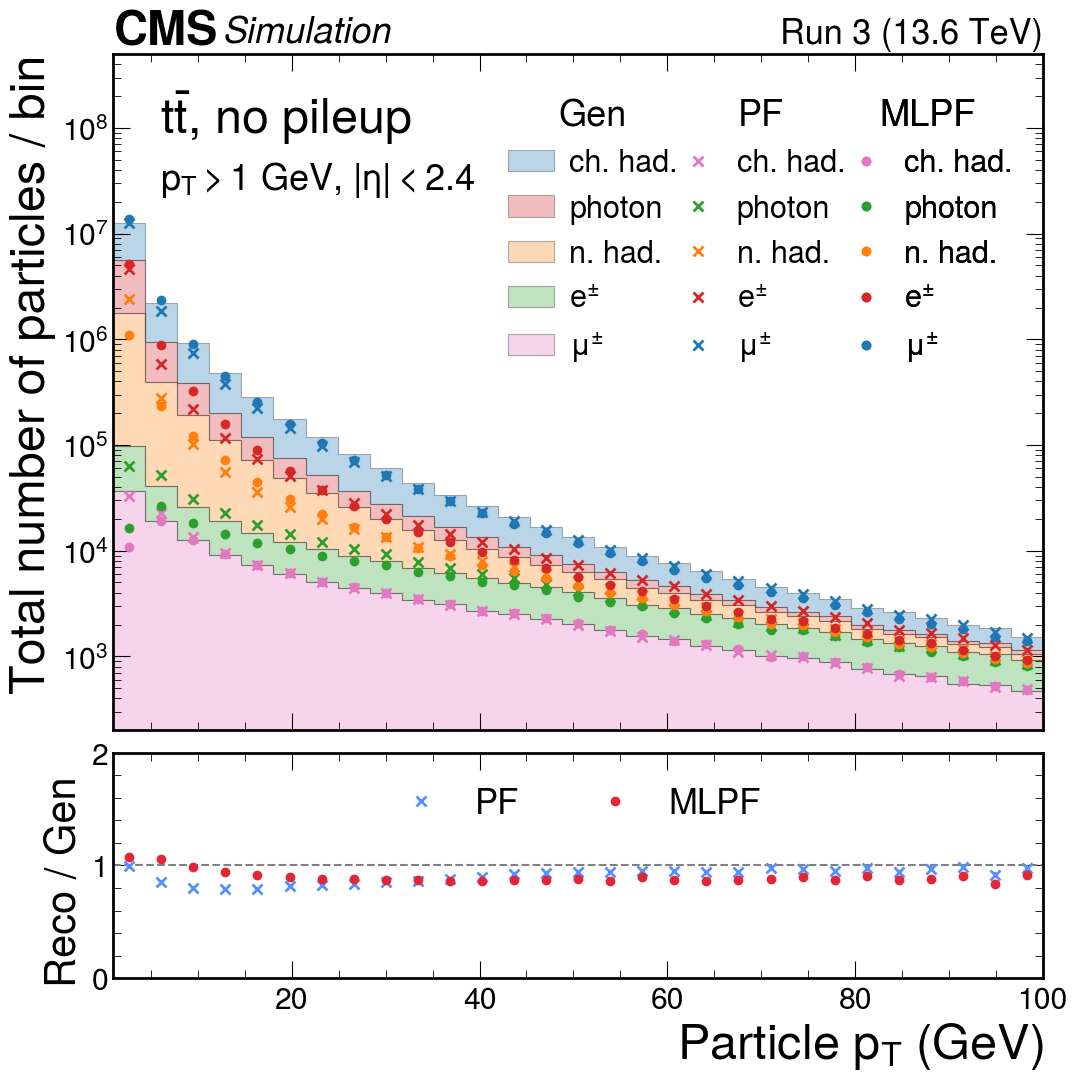

In [61]:
from matplotlib.lines import Line2D

ylim_dict = {
    "cms_pf_qcd_nopu": 10**12,
    "cms_pf_ttbar_nopu": 5*10**8,
}

bins = np.linspace(1,100,30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(12, 12), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries = []
mlpf_entries = []
for pid in [
    13,
    11,
    130,
    22,    
    211,
]:

    # Gen
    sel = (data_pf["GenCands_pid"] == pid) & (abs(data_pf["GenCands_pt"]) > 1) & (abs(data_pf["GenCands_eta"]) < 2.4)
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_pt"][sel]))
        
    total_yield = len(X_gen)
    gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # PF
    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 1) & (abs(data_pf["PFCands_eta"]) < 2.4)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_pt"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))
    
    # MLPF
    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 1) & (abs(data_mlpf["PFCands_eta"]) < 2.4)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_pt"][sel]))
        
    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))


#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

#### PF legend
pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["PF"], markersize=7, markeredgewidth=2,
        label=f"PF {pf_labels[i]}",
        color=pf_colors[i],
    )

#### MLPF legend
mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["MLPF"], markersize=6, markeredgewidth=1,
        label=f"MLPF {mlpf_labels[i]}",
        color=mlpf_colors[i],
    )


############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]

# Build marker-only legend handles for PF and MLPF
pf_marker_handles = [
    Line2D(
        [0], [0],
        marker=marker_style["PF"],
        linestyle="None",
        color=h[0].get_color(),   # use same color as the plotted PF series
        markersize=7,
        markeredgewidth=2,
    )
    for h in handles_PF
]

mlpf_marker_handles = [
    Line2D(
        [0], [0],
        marker=marker_style["MLPF"],
        linestyle="None",
        color=h[0].get_color(),   # same color as MLPF series
        markersize=6,
        markeredgewidth=1,
    )
    for h in handles_MLPF
] 

if "qcd" in sample:
    bbox_to_anchor_xy = (0.64, 0.92)
else:
    bbox_to_anchor_xy = (0.64, 0.98)
    
    
leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,
    fontsize=22,
    bbox_to_anchor=(bbox_to_anchor_xy[0], bbox_to_anchor_xy[1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
#     handles=handles_PF,
    handles=pf_marker_handles,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,
    fontsize=22,
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*1, bbox_to_anchor_xy[1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
#     handles=handles_MLPF,
    handles=mlpf_marker_handles,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,    
    fontsize=22,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*2, bbox_to_anchor_xy[1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin", fontsize=35)
ax.set_ylim(2*10**2, ylim_dict[sample])
ax.set_xlim(1,100)

cms_label(ax)
sample_label(ax, sample, fontsize=35)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=7, markeredgewidth=2, marker=marker_style["PF"], label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=6, markeredgewidth=1, marker=marker_style["MLPF"], label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylabel("Reco / Gen", fontsize=30)

rax.set_ylim(0, 2)
# rax.legend(fontsize=25, ncol=2, loc="upper center")

# --- Build custom legend handles (marker only, no error bars) ---
ratio_legend_handles = [
    Line2D(
        [0], [0],
        marker=marker_style["PF"],
        linestyle="None",
        markersize=7,
        markeredgewidth=2,
        markeredgecolor=color_code["PF"],
        markerfacecolor=color_code["PF"],
        label="PF",
    ),
    Line2D(
        [0], [0],
        marker=marker_style["MLPF"],
        linestyle="None",
        markersize=6,
        markeredgewidth=1,
        markeredgecolor=color_code["MLPF"],        
        markerfacecolor=color_code["MLPF"],
        label="MLPF",
    ),
]

rax.legend(
    handles=ratio_legend_handles,
    fontsize=25,
    ncol=2,
    loc="upper center"
)

rax.set_xlabel("Particle $p_T$ (GeV)", fontsize=35)
rax.yaxis.set_label_coords(-0.03, 0.9)  # move left/right and up/down

plt.text(0.05, 0.8, r"$p_T>1~$GeV, $|\eta| < 2.4$", transform=ax.transAxes, fontsize=26)

plt.tight_layout()
    
plt.savefig(f"./plots/{save_as[sample]}/particle_pt_dist/{sample}_pt_stacked.pdf")

## eta (Figure 4b)

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/1827467849.py:234: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=7, markeredgewidth=2, marker=marker_style["PF"], label="PF", color=color_code["PF"])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/1827467849.py:235: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=6, markeredgewidth=1, marker=marker_style["MLPF"], label="MLPF", color=color_code["MLPF"])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_52549/1827467849.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorr

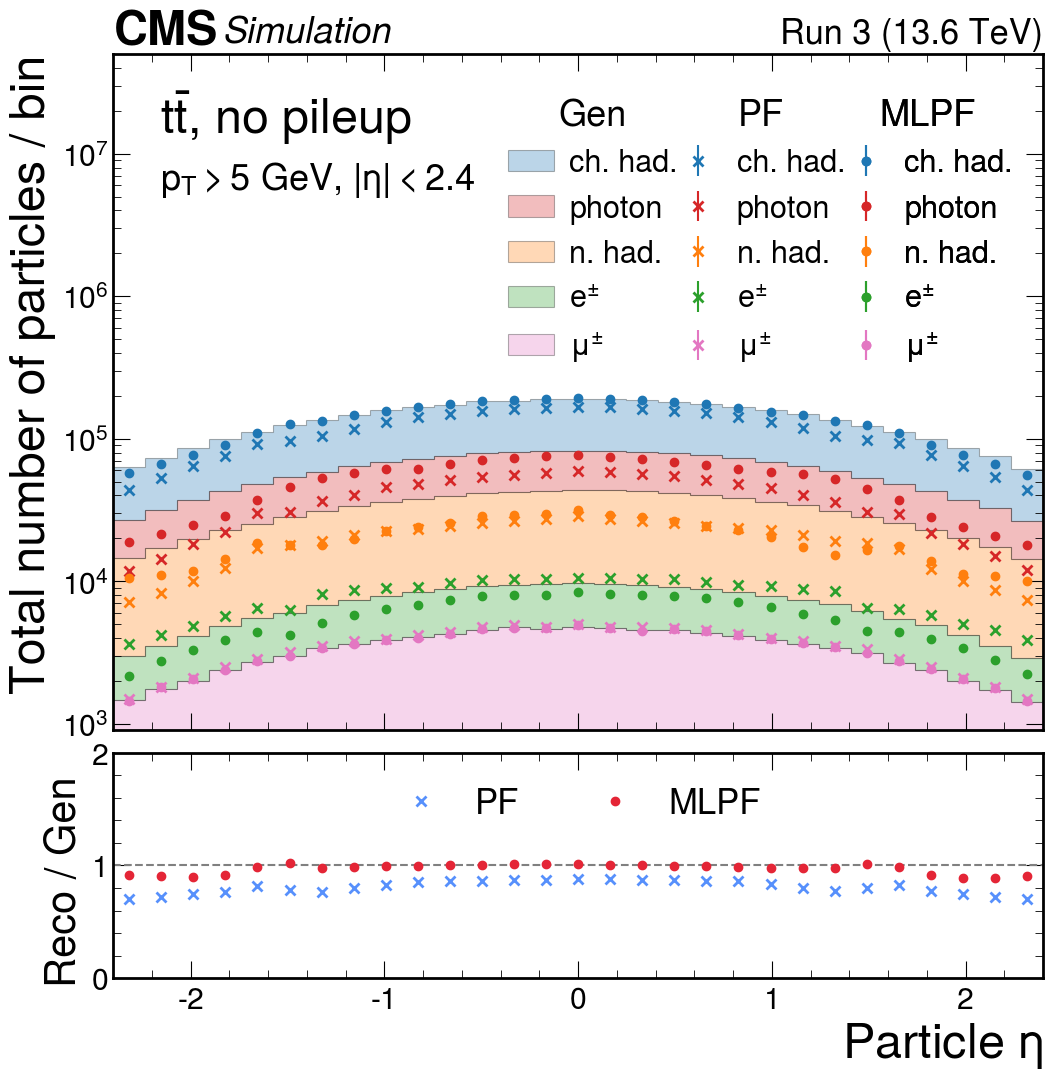

In [62]:
ylim_dict = {
    "cms_pf_qcd_nopu": 10**12,
    "cms_pf_ttbar_nopu": 5*10**7,
}

bins = np.linspace(-2.4,2.4,30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(12, 12), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries = []
mlpf_entries = []
for pid in [
    13,
    11,
    130,
    22,    
    211,
]:

    # Gen
    sel = (data_pf["GenCands_pid"] == pid) & (abs(data_pf["GenCands_pt"]) > 5) & (abs(data_pf["GenCands_eta"]) < 2.4)
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_eta"][sel]))
        
    total_yield = len(X_gen)
    gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # PF
    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 5) & (abs(data_pf["PFCands_eta"]) < 2.4)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))
    
    # MLPF
    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 5) & (abs(data_mlpf["PFCands_eta"]) < 2.4)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))
        
    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))


#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

#### PF legend
pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["PF"], markersize=7, markeredgewidth=2,
        label=f"PF {pf_labels[i]}",
        color=pf_colors[i],
    )

#### MLPF legend
mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["MLPF"], markersize=6, markeredgewidth=1,
        label=f"MLPF {mlpf_labels[i]}",
        color=mlpf_colors[i],
    )


############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]

# Build marker-only legend handles for PF and MLPF
pf_marker_handles = [
    Line2D(
        [0], [0],
        marker=marker_style["PF"],
        linestyle="None",
        color=h[0].get_color(),   # use same color as the plotted PF series
        markersize=7,
        markeredgewidth=2,
    )
    for h in handles_PF
]

mlpf_marker_handles = [
    Line2D(
        [0], [0],
        marker=marker_style["MLPF"],
        linestyle="None",
        color=h[0].get_color(),   # same color as MLPF series
        markersize=6,
        markeredgewidth=1,
    )
    for h in handles_MLPF
]  

if "qcd" in sample:
    bbox_to_anchor_xy = (0.64, 0.92)
else:
    bbox_to_anchor_xy = (0.64, 0.98)
    
    
leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,
    fontsize=22,
    bbox_to_anchor=(bbox_to_anchor_xy[0], bbox_to_anchor_xy[1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
    handles=handles_PF,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,
    fontsize=22,
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*1, bbox_to_anchor_xy[1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
    handles=handles_MLPF,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,    
    fontsize=22,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*2, bbox_to_anchor_xy[1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin", fontsize=35)
# ax.set_ylim(1, ylim_dict[sample]) # TODO
ax.set_ylim(900, ylim_dict[sample])
ax.set_xlim(-2.4,2.4)

cms_label(ax)
sample_label(ax, sample, fontsize=35)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=7, markeredgewidth=2, marker=marker_style["PF"], label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=6, markeredgewidth=1, marker=marker_style["MLPF"], label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylabel("Reco / Gen", fontsize=30)

rax.set_ylim(0, 2)
# rax.legend(fontsize=25, ncol=2, loc="upper center")

# --- Build custom legend handles (marker only, no error bars) ---
ratio_legend_handles = [
    Line2D(
        [0], [0],
        marker=marker_style["PF"],
        linestyle="None",
        markersize=7,
        markeredgewidth=2,
        markeredgecolor=color_code["PF"],
        markerfacecolor=color_code["PF"],
        label="PF",
    ),
    Line2D(
        [0], [0],
        marker=marker_style["MLPF"],
        linestyle="None",
        markersize=6,
        markeredgewidth=1,
        markeredgecolor=color_code["MLPF"],        
        markerfacecolor=color_code["MLPF"],
        label="MLPF",
    ),
]

rax.legend(
    handles=ratio_legend_handles,
    fontsize=25,
    ncol=2,
    loc="upper center"
)

rax.set_xlabel("Particle $\eta$", fontsize=35)
rax.yaxis.set_label_coords(-0.03, 0.9)  # move left/right and up/down

plt.text(0.05, 0.8, r"$p_T>5~$GeV, $|\eta| < 2.4$", transform=ax.transAxes, fontsize=26)

plt.tight_layout()

plt.savefig(f"./plots/{save_as[sample]}/particle_eta_dist/{sample}_eta_stacked_5GeV.pdf")

In [ ]:
######## plot inclusive in eta and splits HF types

pid_to_text[-1] = "forward particles"
col_pid[-1] = "tab:brown"

pid_to_text[1] = "HFEM"
pid_to_text[2] = "HFHAD"

ylim_dict = {
    "cms_pf_qcd_nopu": 10**16,
    "cms_pf_ttbar_nopu": 10**14,
}

# bins = np.linspace(-5,5,50)
bins = np.arange(-5, 5.25, 0.25)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(12, 12), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries, pf_entries_forward, pf_entries_central = [], [], []
mlpf_entries, mlpf_entries_forward, mlpf_entries_central = [], [], []

forward_order = [2, 3, 6, 5, 4, 1, 0]

for pid in [
    2,
    1,
    13,
    11,
    130,    
    22,
    211,
]:
    
    # Gen
    if (pid != 1) and (pid != 2):
        sel = (data_pf["GenCands_pid"] == pid) & (abs(data_pf["GenCands_pt"]) > 1)
        X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_eta"][sel]))

        total_yield = len(X_gen)
        gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # must deal with central and forward region differently because of the stacking
    ########### inclusive (will be used for ratio plot)
    # PF
    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 1) 
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))

    # MLPF
    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 1)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))

    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
    
    ########### central
    # PF
    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 1) & (abs(data_pf["PFCands_eta"]) < 2.4)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    total_yield = len(X_pf)
    pf_entries_central.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))

    # MLPF
    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 1) & (abs(data_mlpf["PFCands_eta"]) < 2.4)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))

    total_yield = len(X_mlpf)
    mlpf_entries_central.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
        
    ########### forward
    # PF
    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 1) & (abs(data_pf["PFCands_eta"]) > 2.4)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    total_yield = len(X_pf)
    pf_entries_forward.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))

    # MLPF
    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 1) & (abs(data_mlpf["PFCands_eta"]) > 2.4)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))

    total_yield = len(X_mlpf)
    mlpf_entries_forward.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
                
# plot gen
#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

#### PF legend
pf_data_list_forward = [entry[1] for entry in pf_entries_forward]
pf_labels_forward    = [entry[2] for entry in pf_entries_forward]
pf_colors_forward    = [entry[3] for entry in pf_entries_forward]

# pf_data_list_forward.reverse()
# pf_labels_forward.reverse()
# pf_colors_forward.reverse()

tmp = [pf_data_list_forward[i] for i in forward_order]
pf_data_list_forward = tmp

tmp = [pf_labels_forward[i] for i in forward_order]
pf_labels_forward = tmp

tmp = [pf_colors_forward[i] for i in forward_order]
pf_colors_forward = tmp

for i in range(len(pf_labels_forward)):
    
    if i == 0:
        cum_sum = pf_data_list_forward[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list_forward[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
        fmt=marker_style["PF"], markersize=4, markeredgewidth=1,        
#         label=f"PF {pf_labels_forward[i]}",
        color=pf_colors_forward[i],
    )
    
#### PF legend
pf_data_list_central = [entry[1] for entry in pf_entries_central]
pf_labels_central    = [entry[2] for entry in pf_entries_central]
pf_colors_central    = [entry[3] for entry in pf_entries_central]

for i in range(len(pf_labels_central)):
    
    if i == 0:
        cum_sum = pf_data_list_central[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list_central[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
        fmt=marker_style["PF"], markersize=4, markeredgewidth=1,        
        label=f"PF {pf_labels_central[i]}",
        color=pf_colors_central[i],
    )
    
#### MLPF legend
mlpf_data_list_forward = [entry[1] for entry in mlpf_entries_forward]
mlpf_labels_forward    = [entry[2] for entry in mlpf_entries_forward]
mlpf_colors_forward    = [entry[3] for entry in mlpf_entries_forward]

# mlpf_data_list_forward.reverse()
# mlpf_labels_forward.reverse()
# mlpf_colors_forward.reverse()

tmp = [mlpf_data_list_forward[i] for i in forward_order]
mlpf_data_list_forward = tmp

tmp = [mlpf_labels_forward[i] for i in forward_order]
mlpf_labels_forward = tmp

tmp = [mlpf_colors_forward[i] for i in forward_order]
mlpf_colors_forward = tmp

for i in range(len(mlpf_labels_forward)):
    if i == 0:
        cum_sum = mlpf_data_list_forward[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list_forward[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
        
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
        fmt=marker_style["MLPF"], markersize=4, markeredgewidth=1,
#         label=f"MLPF {mlpf_labels_forward[i]}",
        color=mlpf_colors_forward[i],
    )

mlpf_data_list_central = [entry[1] for entry in mlpf_entries_central]
mlpf_labels_central    = [entry[2] for entry in mlpf_entries_central]
mlpf_colors_central    = [entry[3] for entry in mlpf_entries_central]

for i in range(len(mlpf_labels_central)):
    if i == 0:
        cum_sum = mlpf_data_list_central[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list_central[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
        
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
        fmt=marker_style["MLPF"], markersize=4, markeredgewidth=1,
        label=f"MLPF {mlpf_labels_central[i]}",
        color=mlpf_colors_central[i],
    )

############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]        

if "qcd" in sample:
    bbox_to_anchor_xy = (0.64, 0.92)
else:
    bbox_to_anchor_xy = (0.64, 0.98)
    
leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[0], bbox_to_anchor_xy[1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
    handles=handles_PF,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*1, bbox_to_anchor_xy[1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
    handles=handles_MLPF,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,    
    fontsize=20,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*2, bbox_to_anchor_xy[1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin", fontsize=35)
ax.set_ylim(1, ylim_dict[sample])
ax.set_xlim(-5,5)

cms_label(ax)
sample_label(ax, sample, fontsize=35)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, marker=marker_style["PF"], label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, marker=marker_style["MLPF"], label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylabel("Reco / Gen")

rax.set_ylim(0, 2)
rax.legend(fontsize=25, ncol=2, loc="upper center")

rax.set_xlabel(r"particle $\eta$", fontsize=35)
rax.yaxis.set_label_coords(-0.03, 0.9)  # move left/right and up/down

plt.text(0.05, 0.8, r"$p_T>1~$GeV", transform=ax.transAxes, fontsize=26)

plt.tight_layout()

plt.savefig(f"./plots/{save_as[sample]}/particle_eta_dist/{sample}_eta_stacked.pdf")

## phi

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": 10**16,
    "cms_pf_ttbar_nopu": 10**13,    
}

bins = np.linspace(-3,3,50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(12, 12), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries = []
mlpf_entries = []
for pid in [
    13,
    11,
    130,
    22,    
    211,
]:

    # Gen
    sel = (data_pf["GenCands_pid"] == pid) & (abs(data_pf["GenCands_eta"]) < 2.4) & (abs(data_pf["GenCands_pt"]) > 1)
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_phi"][sel]))
    
    total_yield = len(X_gen)
    gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # PF
    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_eta"]) < 2.4) & (abs(data_pf["PFCands_pt"]) > 1)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_phi"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))
    
    # MLPF
    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_eta"]) < 2.4) & (abs(data_mlpf["PFCands_pt"]) > 1)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_phi"][sel]))
    
    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
        
#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

#### PF legend
pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["PF"], markersize=4, markeredgewidth=1,
        label=f"PF {pf_labels[i]}",
        color=pf_colors[i],
    )

#### MLPF legend
mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["MLPF"], markersize=4, markeredgewidth=1,
        label=f"MLPF {mlpf_labels[i]}",
        color=mlpf_colors[i],
    )

############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]        

bbox_to_anchor_xy = (0.64, 0.98)
    
leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,
    fontsize=22,
    bbox_to_anchor=(bbox_to_anchor_xy[0], bbox_to_anchor_xy[1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
    handles=handles_PF,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,
    fontsize=22,
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*1, bbox_to_anchor_xy[1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
    handles=handles_MLPF,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=26,    
    fontsize=22,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[0]+0.18*2, bbox_to_anchor_xy[1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin", fontsize=35)

ax.set_ylim(1, ylim_dict[sample])
ax.set_xlim(-3,3)

cms_label(ax)
if "qcd" in sample:
    sample_label(ax, sample, fontsize=30)
else:
    sample_label(ax, sample, fontsize=30)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, marker=marker_style["PF"], label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, marker=marker_style["MLPF"], label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylim(0, 2)
rax.set_ylabel("Reco / Gen")

rax.set_ylim(0, 2)
rax.legend(fontsize=25, ncol=2, loc="upper center")

rax.set_xlabel(r"Particle $\phi$", fontsize=35)

plt.text(0.03, 0.82, r"$p_T>1~$GeV, $|\eta| < 2.4$", transform=ax.transAxes, fontsize=26)

plt.savefig(f"./plots/{save_as[sample]}/particle_phi_dist/{sample}_phi_stacked.pdf")

# Kinematic distributions

## pT

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**10,
        130: 10**8,
        22: 10**10,
        11: 10**7,
        13: 10**6,
        2: 10**6,
        1: 10**6,        
    },
    "cms_pf_ttbar_nopu": {
        211: 10**10,
        130: 10**8,
        22: 10**10,
        11: 10**7,
        13: 10**6,
        2: 10**6,
        1: 10**6,        
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0,2),
        130: (0,2.2),
        22: (0,4),
        11: (0,8),
        13: (0,4),
        2: (0,4),
        1: (0,4),        
    },
    "cms_pf_ttbar_nopu": {
        211: (0.5,1.5),
        130: (0,2),
        22: (0,2.5),
        11: (0,3),
        13: (0,2.4),
        2: (0,2.4),
        1: (0,2.4),        
    },    
}

bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(1,500,41),
        130: np.linspace(1,200,41),
        22: np.linspace(1,200,41),
        11: np.linspace(1,50,21),
        13: np.linspace(1,50,21),
        2: np.linspace(1,50,21),
        1: np.linspace(1,50,21),        
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(1,100,31),
        130: np.linspace(1,40,31),
        22: np.linspace(1,40,31),
        11: np.linspace(1,100,31),
        13: np.linspace(1,100,31),   
    },  
}

eta_cut = 2.4

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = (abs(data_pf["GenCands_pid"]) == pid)  & (abs(data_pf["GenCands_pt"]) > 1)
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_pt"][sel]))

    sel = (abs(data_pf["PFCands_pid"]) == pid) & (abs(data_pf["PFCands_pt"]) > 1) 
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_pt"][sel]))

    sel = (abs(data_mlpf["PFCands_pid"]) == pid) & (abs(data_mlpf["PFCands_pt"]) > 1)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_pt"][sel]))

    bins = bins_pt[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(1)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=30)
        
    plt.text(0.03, 0.82, pid_to_text[pid] + f", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")
    
    if sample=="cms_pf_ttbar_nopu":
        if ( (pid==211) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates
    else:
#         if ( (pid==22) ):
        rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates    
            
            
    rax.set_xlabel("$p_T$ (GeV)")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_pt_dist/{sample}_pt_{pid}.pdf")

## eta

In [ ]:
bins_eta = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-2.4,2.4,41),
        130: np.linspace(-2.4,2.4,41),
        22: np.linspace(-2.4,2.4,41),
        11: np.linspace(-2.4,2.4,41),
        13: np.linspace(-2.4,2.4,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-5,5,41),
        130: np.linspace(-5,5,41),
        22: np.linspace(-5,5,41),
        11: np.linspace(-5,5,41),
        13: np.linspace(-5,5,41),
        2: np.linspace(-5,5,31),
        1: np.linspace(-5,5,31),        
    },
}

ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**10,
        130: 10**8,
        22: 10**10,
        11: 10**7,
        13: 10**6,
        2: 10**6,
        1: 10**6,        
    },
    "cms_pf_ttbar_nopu": {
        211: 10**10,
        130: 10**8,
        22: 10**10,
        11: 10**7,
        13: 10**6,
        2: 10**6,
        1: 10**6,        
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0.8,1.6),
        130: (0,3),
        22: (0,2),
        11: (0,2.5),
        13: (0,5),
        2: (0,5),
        1: (0,5),        
    },
    "cms_pf_ttbar_nopu": {
        211: (0.4,1.6),
        130: (0,2),
        22: (0,1.7),
        11: (0,2),
        13: (0,2),
        2: (0,2),
        1: (0,2),        
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = (data_pf["GenCands_pid"] == pid) & (abs(data_pf["GenCands_pt"]) > 1)
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_eta"][sel]))

    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 1)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 1)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))

    bins = bins_eta[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(-3,3)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=30)
        
    plt.text(0.03, 0.82, pid_to_text[pid] + ", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")
    
    if sample=="cms_pf_qcd_nopu":
        if (pid==211):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

    if sample=="cms_pf_ttbar_nopu":
        if ( (pid==211) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates    
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates
            
    rax.set_xlabel(r"$\eta$")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.xlim(-5, 5)
        
    plt.savefig(f"./plots/{save_as[sample]}/particle_eta_dist/{sample}_eta_{pid}.pdf")

## phi

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**10,
        130: 10**8,
        22: 10**10,
        11: 10**7,
        13: 10**6,
    },
    "cms_pf_ttbar_nopu": {
        211: 10**10,
        130: 10**8,
        22: 10**10,
        11: 10**7,
        13: 10**6,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0.5,2),
        130: (0.5,1.5),
        22: (0,2),
        11: (0,2),
        13: (0,4),
    },
    "cms_pf_ttbar_nopu": {
        211: (0.5,1.6),
        130: (0.3,1.8),
        22: (0,2),
        11: (0,2),
        13: (0.5,1.6),
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = (data_pf["GenCands_pid"] == pid)  & (abs(data_pf["GenCands_pt"]) > 1)
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_phi"][sel]))

    sel = (data_pf["PFCands_pid"] == pid) & (abs(data_pf["PFCands_pt"]) > 1)
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_phi"][sel]))

    sel = (data_mlpf["PFCands_pid"] == pid) & (abs(data_mlpf["PFCands_pt"]) > 1)
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_phi"][sel]))

    bins = bins_phi[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(-3,3)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=30)
        
    plt.text(0.03, 0.82, pid_to_text[pid] + ", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")

    if sample=="cms_pf_qcd_nopu":
        if ( (pid==211) | (pid==130) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates    
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

    if sample=="cms_pf_ttbar_nopu":
        if ( (pid==211) | (pid==130) | (pid==13) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates  

    rax.set_xlabel(r"$\phi$")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_phi_dist/{sample}_phi_{pid}.pdf")

# Matching Gen-to-Reco

## Visualization in dR

In [ ]:
dr_circle_size = 0.15   ###### specify dR threshold
pid = 22
pt_cut = 0.5

iev = 4

plt.figure(figsize=(8,8))
ax = plt.gca()  # Get the current axis to add patches

msk_pid_gen = data_pf["GenCands_pid"] == pid
eta_vals = data_pf["GenCands_eta"][msk_pid_gen][iev]
phi_vals = data_pf["GenCands_phi"][msk_pid_gen][iev]
pt_vals  = data_pf["GenCands_pt"][msk_pid_gen][iev]

eta_vals = eta_vals[pt_vals>pt_cut]
phi_vals = phi_vals[pt_vals>pt_cut]
pt_vals = pt_vals[pt_vals>pt_cut]

plt.scatter(eta_vals, phi_vals, s=pt_vals, color='tab:cyan', label=f'GenCand ({pid_to_text[pid]}, pT>{pt_cut}GeV)')

# Draw ΔR=0.1 cones
for eta, phi in zip(eta_vals, phi_vals):
    circle = Circle((eta, phi), dr_circle_size, color='tab:cyan', alpha=0.3, fill=False, linewidth=1)
    ax.add_patch(circle)

plt.scatter(data_pf["PFCands_eta"][iev], data_pf["PFCands_phi"][iev], s=data_pf["PFCands_pt"][iev], marker="x", color="red", alpha=0.5, label="All PFCands")

plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.xlabel("η")
plt.ylabel("ϕ")
plt.legend()
plt.title(f"ΔR={dr_circle_size} circles around GenCands", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./plots/{save_as[sample]}/particle_dR_circles/gencands_dRcircles_{dr_circle_size}.pdf")

In [ ]:
dr_circle_size = 0.15   ###### specify dR threshold
pids = [13, 211]
pt_cut = (48,54)

use_MLPF = True

if use_MLPF:
    data = data_mlpf
else:
    data = data_pf

for iev in range(len(data_mlpf)):

    if iev != 4168:
        continue
        
    msk_pid_reco = (data["PFCands_pid"] == 13) #| (data["PFCands_pid"] == 211)    
    eta_vals = data["PFCands_eta"][msk_pid_reco][iev]
    phi_vals = data["PFCands_phi"][msk_pid_reco][iev]
    pt_vals  = data["PFCands_pt"][msk_pid_reco][iev]

    eta_vals = eta_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    phi_vals = phi_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    pt_vals = pt_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]

#     if len(pt_vals) == 0:
#         continue
    
    plt.figure(figsize=(10,10))
    ax = plt.gca()  # Get the current axis to add patches
    
    if use_MLPF:
        plt.scatter(eta_vals, phi_vals, s=pt_vals, color='red', label=f'MLPFCand ({pid_to_text[pid]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV)')
    else:
        plt.scatter(eta_vals, phi_vals, s=pt_vals, color='red', label=f'PFCand ({pid_to_text[pid]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV)')

    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='red', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)

#     plt.scatter(
#         data["GenCands_eta"][iev], 
#         data["GenCands_phi"][iev], 
#         s=data["GenCands_pt"][iev], 
#         marker="x", color="tab:cyan", alpha=0.9, label="All GenCands"
#     )

#     msk_gen = (data_mlpf["GenCands_pt"] > 48) & (data_mlpf["GenCands_pt"] < 54) & (abs(data_mlpf["GenCands_pid"]) == 13 )


    msk_gen = (abs(data_mlpf["GenCands_pid"]) == 13 ) 
    print(data["GenCands_pt"][msk_gen][iev])
    
    plt.scatter(
        data["GenCands_eta"][msk_gen][iev], 
        data["GenCands_phi"][msk_gen][iev], 
        s=data["GenCands_pt"][msk_gen][iev], 
        marker="x", color="tab:cyan", alpha=0.9, label=f"GenCands (muons w/ pt = {data['GenCands_pt'][msk_gen][iev]})"
    )
    
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.xlabel("η")
    plt.ylabel("ϕ")
    plt.legend()
    plt.title(f"ΔR={dr_circle_size} circles around PFCands, ev#{iev}", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
#     plt.savefig(f"./plots/{save_as[sample]}/particle_dR_circles/pfcands_dRcircles_{dr_circle_size}.pdf")
    plt.show()

In [ ]:
dr_circle_size = 0.15   ###### specify dR threshold
pt_cut = (0,200)
pid = 1

use_MLPF = False

if use_MLPF:
    data = data_mlpf
else:
    data = data_pf

for iev in range(len(data_mlpf)):
    
    if iev != 10:
        continue
    
    plt.figure(figsize=(16,10))
    ax = plt.gca()  # Get the current axis to add patches
            
        
    msk_pid_reco = (data["PFCands_pid"] == 1)
    eta_vals = data["PFCands_eta"][msk_pid_reco][iev]
    phi_vals = data["PFCands_phi"][msk_pid_reco][iev]
    pt_vals  = data["PFCands_pt"][msk_pid_reco][iev]

    eta_vals = eta_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    phi_vals = phi_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    pt_vals = pt_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]

    if use_MLPF:
        plt.scatter(
            eta_vals, 
            phi_vals, 
#             s=pt_vals, 
#             color='red', label=f'MLPF {pid_to_text[pid]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV')
            color='red', label=f'MLPF {pid_to_text[1]}')        
    else:
        plt.scatter(
            eta_vals, 
            phi_vals, 
#             s=pt_vals, 
            color='red', label=f'PF {pid_to_text[1]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV')        

    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='red', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)
        
    msk_pid_reco = (data["PFCands_pid"] == 2)
    eta_vals = data["PFCands_eta"][msk_pid_reco][iev]
    phi_vals = data["PFCands_phi"][msk_pid_reco][iev]
    pt_vals  = data["PFCands_pt"][msk_pid_reco][iev]

    eta_vals = eta_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    phi_vals = phi_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    pt_vals = pt_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]

    
    if use_MLPF:
        plt.scatter(
            eta_vals, 
            phi_vals, 
#             s=pt_vals, 
#             color='red', label=f'MLPF {pid_to_text[pid]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV')
            color='green', label=f'MLPF {pid_to_text[2]}')        
    else:
        plt.scatter(
            eta_vals, 
            phi_vals, 
#             s=pt_vals, 
            color='green', label=f'PF {pid_to_text[2]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV')        

    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='green', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)
        
        
#     plt.scatter(
#         data["GenCands_eta"][iev], 
#         data["GenCands_phi"][iev], 
#         s=data["GenCands_pt"][iev], 
#         marker="x", color="tab:cyan", alpha=0.9, label="All GenCands"
#     )
#     msk_gen = (data_mlpf["GenCands_pt"] > 48) & (data_mlpf["GenCands_pt"] < 54) & (abs(data_mlpf["GenCands_pid"]) == 13 )

    genpid = 211
    msk_gen = (abs(data["GenCands_pid"]) == genpid ) 
    plt.scatter(
        data["GenCands_eta"][msk_gen][iev], 
        data["GenCands_phi"][msk_gen][iev], 
#         s=data["GenCands_pt"][msk_gen][iev], 
        marker="x", color="tab:cyan", alpha=0.9, label=f"Gen {pid_to_text[genpid]}"
    )
    
    genpid = 22
    msk_gen = (abs(data["GenCands_pid"]) == genpid ) 
    plt.scatter(
        data["GenCands_eta"][msk_gen][iev], 
        data["GenCands_phi"][msk_gen][iev], 
#         s=data["GenCands_pt"][msk_gen][iev], 
        marker="x", color="tab:orange", alpha=0.9, label=f"Gen {pid_to_text[genpid]}"
    )
    
    genpid = 130
    msk_gen = (abs(data["GenCands_pid"]) == genpid ) 
    plt.scatter(
        data["GenCands_eta"][msk_gen][iev], 
        data["GenCands_phi"][msk_gen][iev], 
#         s=data["GenCands_pt"][msk_gen][iev], 
        marker="x", color="tab:purple", alpha=0.9, label=f"Gen {pid_to_text[genpid]}"
    )    
        
    genpid = 11
    msk_gen = (abs(data["GenCands_pid"]) == genpid ) 
    plt.scatter(
        data["GenCands_eta"][msk_gen][iev], 
        data["GenCands_phi"][msk_gen][iev], 
#         s=data["GenCands_pt"][msk_gen][iev], 
        marker="x", color="tab:brown", alpha=0.9, label=f"Gen {pid_to_text[genpid]}"
    )    
        
    genpid = 13
    msk_gen = (abs(data["GenCands_pid"]) == genpid ) 
    plt.scatter(
        data["GenCands_eta"][msk_gen][iev], 
        data["GenCands_phi"][msk_gen][iev], 
#         s=data["GenCands_pt"][msk_gen][iev], 
        marker="x", color="tab:brown", alpha=0.9, label=f"Gen {pid_to_text[genpid]}"
    )    
            
    
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel("η")
    plt.ylabel("ϕ")
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.8), 
    )
    plt.title(f"ΔR={dr_circle_size} circles around RecoCands, ev#{iev}", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
#     plt.savefig(f"./plots/{save_as[sample]}/particle_dR_circles/pfcands_dRcircles_{dr_circle_size}.pdf")
    plt.show()

# Efficiency (with the option of isolation)

In [ ]:
sel_eta_inclusive = False

sel_isolation_gen = False  # change that
sel_isolation_reco = False

# must define matching condition
dR_cut = 0.15
pt_cut = 1

if sel_eta_inclusive:
    eta_cut = float('inf')    
else:
    eta_cut = 2.4

# define baseline kinematic cuts
msk_pf_gen_pt = data_pf["GenCands_pt"] > pt_cut
msk_pf_gen_eta = (abs(data_pf["GenCands_eta"]) < eta_cut)
msk_pf_gen = msk_pf_gen_pt & msk_pf_gen_eta

if sel_isolation_gen:
    msk_pf_gen = msk_pf_gen & (data_pf["GenCands_reliso03"] < 0.2)    

msk_pf_reco_pt = data_pf["PFCands_pt"] > pt_cut
msk_pf_reco_eta = (abs(data_pf["PFCands_eta"]) < eta_cut)
msk_pf_reco = msk_pf_reco_pt & msk_pf_reco_eta

if sel_isolation_reco:
    msk_pf_reco = msk_pf_reco & (data_pf["PFCands_reliso03"] < 0.2)

# apply baseline kinematic cuts
eta1 = data_pf["GenCands_eta"][msk_pf_gen]
phi1 = data_pf["GenCands_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

# define baseline kinematic cuts
msk_mlpf_gen_pt = data_mlpf["GenCands_pt"] > pt_cut
msk_mlpf_gen_eta = (abs(data_mlpf["GenCands_eta"]) < eta_cut)
msk_mlpf_gen = msk_mlpf_gen_pt & msk_mlpf_gen_eta

if sel_isolation_gen:
    msk_mlpf_gen = msk_mlpf_gen & (data_mlpf["GenCands_reliso03"] < 0.2)

msk_mlpf_reco_pt = data_mlpf["PFCands_pt"] > pt_cut
msk_mlpf_reco_eta = (abs(data_mlpf["PFCands_eta"]) < eta_cut)
msk_mlpf_reco = msk_mlpf_reco_pt & msk_mlpf_reco_eta

if sel_isolation_reco:
    msk_mlpf_reco = msk_mlpf_reco & (data_mlpf["PFCands_reliso03"] < 0.2)

# apply baseline kinematic cuts
eta1 = data_mlpf["GenCands_eta"][msk_mlpf_gen]
phi1 = data_mlpf["GenCands_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)


bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(1,500,41),
        130: np.linspace(1,200,41),
        22: np.linspace(1,200,41),
        11: np.linspace(1,50,21),
        13: np.linspace(1,50,21),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(1,100,31),
        130: np.linspace(1,60,21),
        22: np.linspace(1,40,21),
        11: np.linspace(1,200,21),
        13: np.linspace(1,200,21),
    },  
}


match_pid = False

for pid in [
#     211,
    130,
#     22,
#     11,
#     13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen = to_bh(
        ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), 
        bins=bins_pt[sample][pid],
    )

    msk_eff = (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid) 

    h_pf_gen_matched = to_bh(
        ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][pf_idx1][msk_eff]),
        bins=bins_pt[sample][pid]
    )

    #pick recoparticles, and recoparticles matched to gen
    msk_reco_pid = (data_pf["PFCands_pid"][msk_pf_reco]==pid)
    h_pf_reco = to_bh(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][msk_reco_pid]), 
        bins=bins_pt[sample][pid]
    )
    
    msk_fakerate = (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)  
   
    h_pf_reco_matched = to_bh(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][msk_fakerate]), 
        bins=bins_pt[sample][pid]
    )

    #repeat for mlpf
    h_mlpf_gen = to_bh(
        ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), 
        bins=bins_pt[sample][pid]
    )
    msk_eff = (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid) 

    h_mlpf_gen_matched = to_bh(
        ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1][msk_eff]),
        bins=bins_pt[sample][pid]
    )


    msk_reco_pid = (data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid)
    h_mlpf_reco = to_bh(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][msk_reco_pid]), 
        bins=bins_pt[sample][pid]
    )


    msk_fakerate = (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid)    
    if match_pid:
        msk_fakerate = msk_fakerate & (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    h_mlpf_reco_matched = to_bh(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]), 
        bins=bins_pt[sample][pid]
    )
    
    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.3)
    if match_pid:
        plt.ylabel("Efficiency (w/ matched PID)", fontsize=35)
    else:
        plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("Particle $p_T^{gen}$ (GeV)", fontsize=35)
    plt.legend(loc="center right", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=35)

    more_text = ", $p_T>1~$GeV"
    if not sel_eta_inclusive:
        more_text += r", $|\eta|<2.4$"
    if sel_isolation_gen:
        more_text += r", $\mathrm{RelIso03}^{gen}<0.2$"

    plt.text(0.03, 0.85, pid_to_text[pid] + more_text, transform=ax.transAxes, fontsize=30)
        
    plt.tight_layout()
    
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_efficiency_pt_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_efficiency_pt_{pid}.pdf")

# Fakerate (with the option of isolation)

In [ ]:
sel_eta_inclusive = True

sel_isolation_gen = False
sel_isolation_reco = False  # change that

# must define matching condition
dR_cut = 0.15
pt_cut = 1

if sel_eta_inclusive:
    eta_cut = float('inf')
else:
    eta_cut = 2.4

# define baseline kinematic cuts
msk_pf_gen_pt = data_pf["GenCands_pt"] > pt_cut
msk_pf_gen_eta = (abs(data_pf["GenCands_eta"]) < eta_cut)
msk_pf_gen = msk_pf_gen_pt & msk_pf_gen_eta

if sel_isolation_gen:
    msk_pf_gen = msk_pf_gen & (data_pf["GenCands_reliso03"] < 0.2)    

msk_pf_reco_pt = data_pf["PFCands_pt"] > pt_cut
msk_pf_reco_eta = (abs(data_pf["PFCands_eta"]) < eta_cut)
msk_pf_reco = msk_pf_reco_pt & msk_pf_reco_eta

if sel_isolation_reco:
    msk_pf_reco = msk_pf_reco & (data_pf["PFCands_reliso03"] < 0.2)

# apply baseline kinematic cuts
eta1 = data_pf["GenCands_eta"][msk_pf_gen]
phi1 = data_pf["GenCands_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

# define baseline kinematic cuts
msk_mlpf_gen_pt = data_mlpf["GenCands_pt"] > pt_cut
msk_mlpf_gen_eta = (abs(data_mlpf["GenCands_eta"]) < eta_cut)
msk_mlpf_gen = msk_mlpf_gen_pt & msk_mlpf_gen_eta

if sel_isolation_gen:
    msk_mlpf_gen = msk_mlpf_gen & (data_mlpf["GenCands_reliso03"] < 0.2)

msk_mlpf_reco_pt = data_mlpf["PFCands_pt"] > pt_cut
msk_mlpf_reco_eta = (abs(data_mlpf["PFCands_eta"]) < eta_cut)
msk_mlpf_reco = msk_mlpf_reco_pt & msk_mlpf_reco_eta

if sel_isolation_reco:
    msk_mlpf_reco = msk_mlpf_reco & (data_mlpf["PFCands_reliso03"] < 0.2)

# apply baseline kinematic cuts
eta1 = data_mlpf["GenCands_eta"][msk_mlpf_gen]
phi1 = data_mlpf["GenCands_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)


bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(1,500,41),
        130: np.linspace(1,200,41),
        22: np.linspace(1,200,41),
        11: np.linspace(1,50,21),
        13: np.linspace(1,50,21),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(1,100,31),
        130: np.linspace(1,60,21),
        22: np.linspace(1,40,21),
        11: np.linspace(1,200,21),
        13: np.linspace(1,200,21),
    },  
}


match_pid = False

for pid in [
#     211,
    130,
#     22,
#     11,
#     13,
]:

    #pick recoparticles, and recoparticles matched to gen
    msk_reco_pid = (data_pf["PFCands_pid"][msk_pf_reco]==pid)
    if pid == 130:
        msk_reco_pid = msk_reco_pid | (data_pf["PFCands_pid"][msk_pf_reco]==2)
    elif pid == 22:
        msk_reco_pid = msk_reco_pid | (data_pf["PFCands_pid"][msk_pf_reco]==1)
            
    h_pf_reco = to_bh(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][msk_reco_pid]), 
        bins=bins_pt[sample][pid]
    )
    
    msk_fakerate = (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)  
    if pid == 130:
        msk_fakerate = msk_fakerate | (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==2)    
    elif pid == 22:
        msk_fakerate = msk_fakerate | (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==1)
        
    h_pf_reco_matched = to_bh(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][msk_fakerate]), 
        bins=bins_pt[sample][pid]
    )

    #repeat for mlpf
    msk_reco_pid = (data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid)
    if pid == 130:
        msk_reco_pid = msk_reco_pid | (data_mlpf["PFCands_pid"][msk_mlpf_reco]==2)
    elif pid == 22:
        msk_reco_pid = msk_reco_pid | (data_mlpf["PFCands_pid"][msk_mlpf_reco]==1)    
    h_mlpf_reco = to_bh(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][msk_reco_pid]), 
        bins=bins_pt[sample][pid]
    )
    
    msk_fakerate = (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid)    
    if match_pid:
        msk_fakerate = msk_fakerate & (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    if pid == 130:
        msk_fakerate = msk_fakerate | (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==2)    
    elif pid == 22:
        msk_fakerate = msk_fakerate | (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==1)
    h_mlpf_reco_matched = to_bh(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]), 
        bins=bins_pt[sample][pid]
    )
    
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.0)
    if match_pid:
        plt.ylabel("Misidentification", fontsize=35)
    else:
        plt.ylabel("Fake rate", fontsize=35)    
    plt.xlabel("Particle $p_T^{reco}$ (GeV)", fontsize=35)
    plt.legend(loc="center right", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=35)
    
    more_text = ", $p_T>1~$GeV"
    if not sel_eta_inclusive:
        more_text += r", $|\eta|<2.4$"
    if sel_isolation_reco:
        more_text += r", $\mathrm{RelIso03}^{reco}<0.2$"

    plt.text(0.03, 0.85, pid_to_text[pid] + more_text, transform=ax.transAxes, fontsize=30)

    plt.tight_layout()
    
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_fakerate_pt_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_fakerate_pt_{pid}.pdf")

# Make particle-level plots in the paper (Figure 5)

In [21]:
sel_eta_inclusive = False

# if you want to impose any isolation requirement before the matching
sel_isolation_gen = False
sel_isolation_reco = False

# must define matching condition
dR_cut = 0.15
pt_cut = 1

if sel_eta_inclusive:
    eta_cut = float('inf')    
else:
    eta_cut = 2.4

# define baseline kinematic cuts
msk_pf_gen_pt = data_pf["GenCands_pt"] > pt_cut
msk_pf_gen_eta = (abs(data_pf["GenCands_eta"]) < eta_cut)
msk_pf_gen = msk_pf_gen_pt & msk_pf_gen_eta

if sel_isolation_gen:
    msk_pf_gen = msk_pf_gen & (data_pf["GenCands_reliso03"] < 0.2)    

msk_pf_reco_pt = data_pf["PFCands_pt"] > pt_cut
msk_pf_reco_eta = (abs(data_pf["PFCands_eta"]) < eta_cut)
msk_pf_reco = msk_pf_reco_pt & msk_pf_reco_eta

if sel_isolation_reco:
    msk_pf_reco = msk_pf_reco & (data_pf["PFCands_reliso03"] < 0.2)

# apply baseline kinematic cuts
eta1 = data_pf["GenCands_eta"][msk_pf_gen]
phi1 = data_pf["GenCands_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

# define baseline kinematic cuts
msk_mlpf_gen_pt = data_mlpf["GenCands_pt"] > pt_cut
msk_mlpf_gen_eta = (abs(data_mlpf["GenCands_eta"]) < eta_cut)
msk_mlpf_gen = msk_mlpf_gen_pt & msk_mlpf_gen_eta

if sel_isolation_gen:
    msk_mlpf_gen = msk_mlpf_gen & (data_mlpf["GenCands_reliso03"] < 0.2)

msk_mlpf_reco_pt = data_mlpf["PFCands_pt"] > pt_cut
msk_mlpf_reco_eta = (abs(data_mlpf["PFCands_eta"]) < eta_cut)
msk_mlpf_reco = msk_mlpf_reco_pt & msk_mlpf_reco_eta

if sel_isolation_reco:
    msk_mlpf_reco = msk_mlpf_reco & (data_mlpf["PFCands_reliso03"] < 0.2)

# apply baseline kinematic cuts
eta1 = data_mlpf["GenCands_eta"][msk_mlpf_gen]
phi1 = data_mlpf["GenCands_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

## Efficiency / Fake rate as a function of pT (1D)

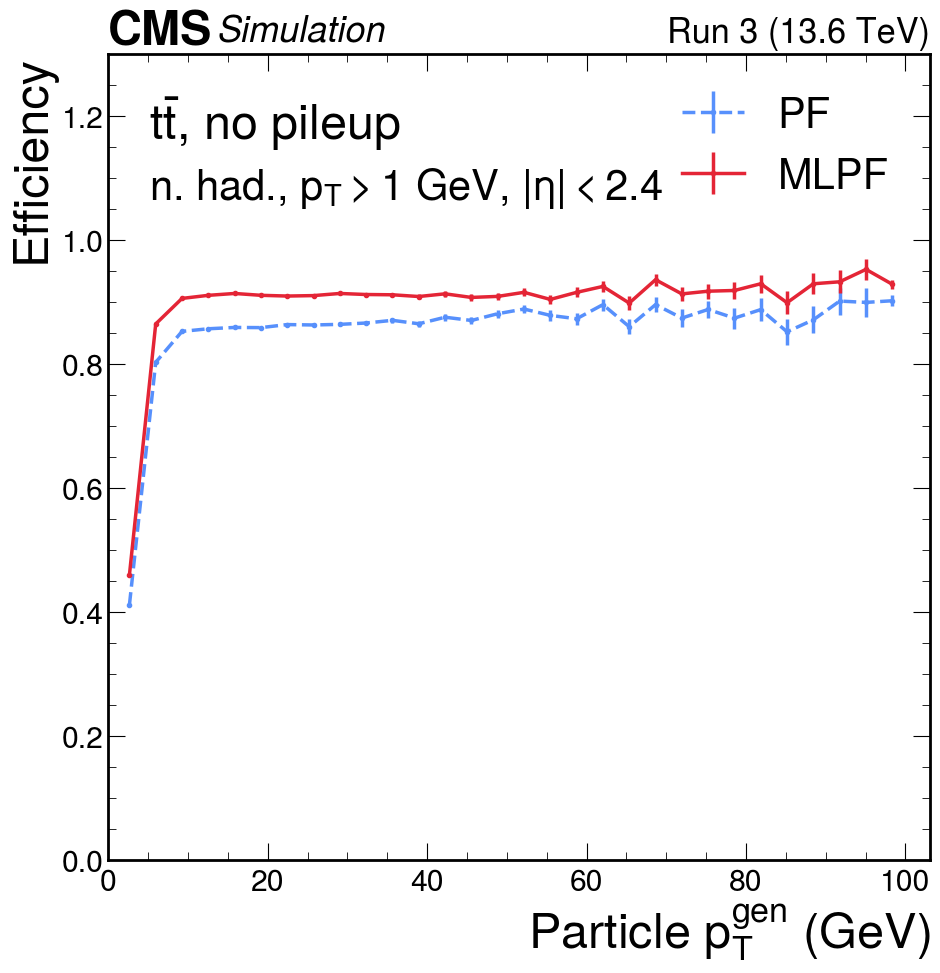

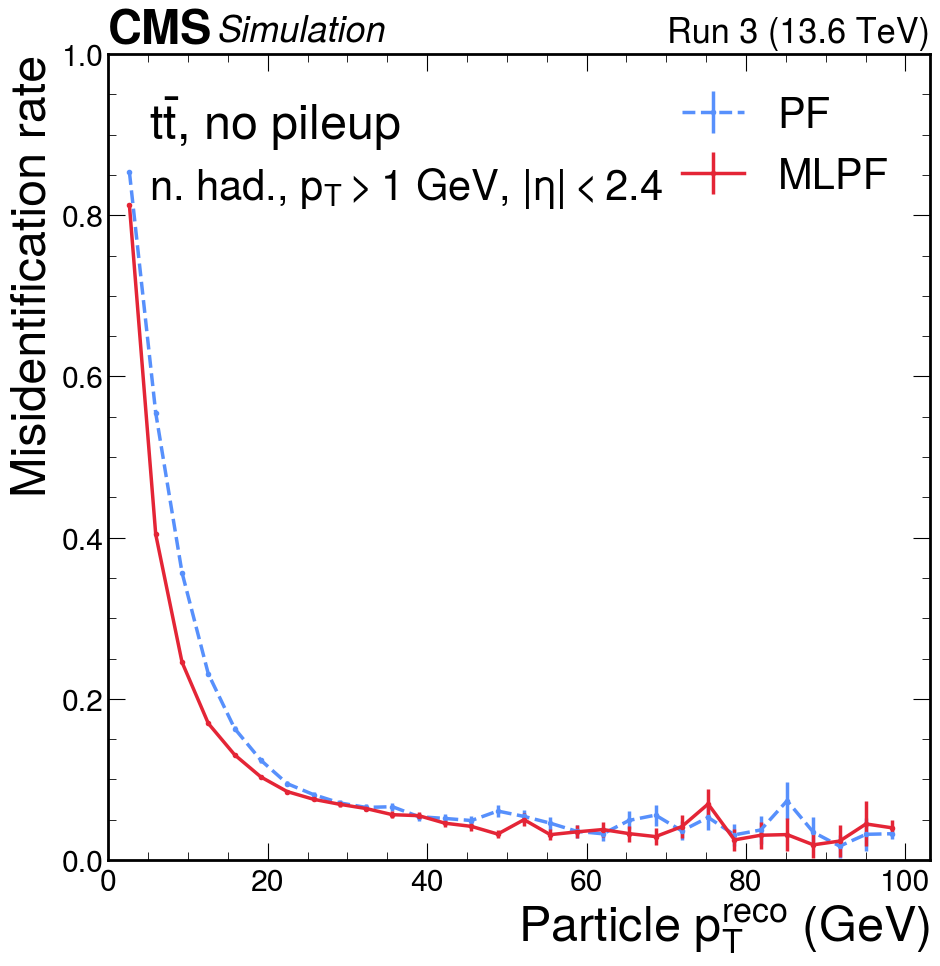

In [60]:
bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(1,500,41),
        130: np.linspace(1,60,21),
        22: np.linspace(1,200,41),
        11: np.linspace(1,50,21),
        13: np.linspace(1,50,21),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(1,100,31),
        130: np.linspace(1,100,31),
        22: np.linspace(1,60,21),
        11: np.linspace(1,100,21),
        13: np.linspace(1,100,21),
    },  
}

match_pid = False

for pid in [
#     211,
    130,
#     22,
#     11,
#     13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen = to_bh(
        ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), 
        bins=bins_pt[sample][pid],
    )

    msk_eff = (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid) 

    h_pf_gen_matched = to_bh(
        ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][pf_idx1][msk_eff]),
        bins=bins_pt[sample][pid]
    )

    #pick recoparticles, and recoparticles matched to gen
    msk_reco_pid = (data_pf["PFCands_pid"][msk_pf_reco]==pid)
    h_pf_reco = to_bh(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][msk_reco_pid]), 
        bins=bins_pt[sample][pid]
    )
    
    msk_fakerate = (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)  
   
    h_pf_reco_matched = to_bh(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][msk_fakerate]), 
        bins=bins_pt[sample][pid]
    )

    #repeat for mlpf
    h_mlpf_gen = to_bh(
        ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), 
        bins=bins_pt[sample][pid]
    )
    msk_eff = (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid) 

    h_mlpf_gen_matched = to_bh(
        ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1][msk_eff]),
        bins=bins_pt[sample][pid]
    )


    msk_reco_pid = (data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid)
    h_mlpf_reco = to_bh(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][msk_reco_pid]), 
        bins=bins_pt[sample][pid]
    )


    msk_fakerate = (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid)    
    if match_pid:
        msk_fakerate = msk_fakerate & (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    h_mlpf_reco_matched = to_bh(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]), 
        bins=bins_pt[sample][pid]
    )
    
    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"], linewidth=2.5,
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"], linewidth=2.5,
    )
    plt.ylim(0, 1.3)
    plt.xlim(0)    
    if match_pid:
        plt.ylabel("Efficiency (w/ matched PID)", fontsize=35)
    else:
        plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("Particle $p_T^{gen}$ (GeV)", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    sample_label(ax, sample, fontsize=35)

    if sel_eta_inclusive:
        plt.text(0.05, 0.82, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=30)
    else:
        plt.text(0.05, 0.82, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta|<2.4$", transform=ax.transAxes, fontsize=30)
        
#     plt.text(0.03, 0.77, r"matching condition ($\Delta R<0.05$)", transform=ax.transAxes, fontsize=20)
    
    plt.tight_layout()
    
    fig.subplots_adjust(bottom=0.11)
    
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_efficiency_pt_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_efficiency_pt_{pid}.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"], linewidth=2.5,
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"], linewidth=2.5,
    )
    plt.ylim(0, 1.0)
    plt.xlim(0)
    if match_pid:
        plt.ylabel("Misidentification", fontsize=35)
    else:
#         plt.ylabel("Fake rate", fontsize=35)
        plt.ylabel("Misidentification rate", fontsize=35)        
    plt.xlabel("Particle $p_T^{reco}$ (GeV)", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    sample_label(ax, sample, fontsize=35)
    
    if sel_eta_inclusive:
        plt.text(0.05, 0.82, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=30)
    else:
        plt.text(0.05, 0.82, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta|<2.4$", transform=ax.transAxes, fontsize=30)
        
#     plt.text(0.03, 0.77, r"matching condition ($\Delta R<0.05$)", transform=ax.transAxes, fontsize=20)

    plt.tight_layout()
    
    fig.subplots_adjust(bottom=0.11)
    
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_fakerate_pt_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_fakerate_pt_{pid}.pdf")

## Efficiency / Fake rate as a function of eta (1D)

In [ ]:
match_pid = False

for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen = to_bh(
        ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), 
        bins=bins_eta[sample][pid],
    )

    msk_eff = (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid) 
        
    h_pf_gen_matched = to_bh(
        ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][pf_idx1][msk_eff]),
        bins=bins_eta[sample][pid]
    )

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco = to_bh(
        ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), 
        bins=bins_eta[sample][pid]
    )
    
    msk_fakerate = (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)  
        
    h_pf_reco_matched = to_bh(
        ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][pf_idx2][msk_fakerate]), 
        bins=bins_eta[sample][pid]
    )

    #repeat for mlpf
    h_mlpf_gen = to_bh(
        ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), 
        bins=bins_eta[sample][pid]
    )
    
    msk_eff = (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid) 

    h_mlpf_gen_matched = to_bh(
        ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][mlpf_idx1][msk_eff]),
        bins=bins_eta[sample][pid]
    )

    h_mlpf_reco = to_bh(
        ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), 
        bins=bins_eta[sample][pid]
    )

    msk_fakerate = (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)        
    
    h_mlpf_reco_matched = to_bh(
        ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]), 
        bins=bins_eta[sample][pid]
    )    
    
    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.25)
    if match_pid:
        plt.ylabel("Efficiency (w/ matched PID)", fontsize=35)
    else:
        plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("Particle $\eta^{gen}$", fontsize=35)
    plt.legend(loc="upper right", fontsize=30)
    cms_label(ax)
    sample_label(ax, sample, fontsize=30)
        
    if sel_eta_inclusive:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)
    else:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta|>2.4$", transform=ax.transAxes, fontsize=25)
        
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_efficiency_eta_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_efficiency_eta_{pid}.pdf")
        
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.0)
    
    plt.xlim(-5, 5)
    
    if match_pid:
        plt.ylabel("Misidentification", fontsize=35)
    else:
        plt.ylabel("Fake rate", fontsize=35)    
    plt.xlabel("Particle $\eta^{reco}$", fontsize=35)
    plt.legend(loc="upper right", fontsize=30)
    cms_label(ax)
    sample_label(ax, sample, fontsize=30)
        
    if sel_eta_inclusive:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)
    else:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta|>2.4$", transform=ax.transAxes, fontsize=25)
        
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_fakerate_eta_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_fakerate_eta_{pid}.pdf")    

## Efficiency / Fake rate as a function of phi (1D)

In [ ]:
match_pid = False

for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen = to_bh(
        ak.flatten(data_pf["GenCands_phi"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), 
        bins=bins_phi[sample][pid],
    )

    msk_eff = (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid) 
        
    h_pf_gen_matched = to_bh(
        ak.flatten(data_pf["GenCands_phi"][msk_pf_gen][pf_idx1][msk_eff]),
        bins=bins_phi[sample][pid]
    )

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco = to_bh(
        ak.flatten(data_pf["PFCands_phi"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), 
        bins=bins_phi[sample][pid]
    )
    
    msk_fakerate = (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)  
        
    h_pf_reco_matched = to_bh(
        ak.flatten(data_pf["PFCands_phi"][msk_pf_reco][pf_idx2][msk_fakerate]), 
        bins=bins_phi[sample][pid]
    )

    #repeat for mlpf
    h_mlpf_gen = to_bh(
        ak.flatten(data_mlpf["GenCands_phi"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), 
        bins=bins_phi[sample][pid]
    )
    
    msk_eff = (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid) 

    h_mlpf_gen_matched = to_bh(
        ak.flatten(data_mlpf["GenCands_phi"][msk_mlpf_gen][mlpf_idx1][msk_eff]),
        bins=bins_phi[sample][pid]
    )

    h_mlpf_reco = to_bh(
        ak.flatten(data_mlpf["PFCands_phi"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), 
        bins=bins_phi[sample][pid]
    )

    msk_fakerate = (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)        
    
    h_mlpf_reco_matched = to_bh(
        ak.flatten(data_mlpf["PFCands_phi"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]), 
        bins=bins_phi[sample][pid]
    )    

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.3)
    if match_pid:
        plt.ylabel("Efficiency (w/ matched PID)", fontsize=35)
    else:
        plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("Particle $\phi^{gen}$")
    plt.legend(loc="best")
    cms_label(ax)
    sample_label(ax, sample, fontsize=30)
    
    if sel_eta_inclusive:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)
    else:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta|>2.4$", transform=ax.transAxes, fontsize=25)
        
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_efficiency_phi_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_efficiency_phi_{pid}.pdf")

    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1)
    if match_pid:
        plt.ylabel("Misidentification", fontsize=35)
    else:
        plt.ylabel("Fake rate", fontsize=35)   
    plt.xlabel("Particle $\phi^{reco}$")
    plt.legend(loc="best")
    cms_label(ax)
    sample_label(ax, sample, fontsize=30)

    if sel_eta_inclusive:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)
    else:
        plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta|>2.4$", transform=ax.transAxes, fontsize=25)
        
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_fakerate_phi_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_fakerate_phi_{pid}.pdf")

## Efficiency / Fake rate as a function of pT, eta (2D)

In [ ]:
def to_bh2d(x, y, bins):
    """
    Create a 2D boost histogram with optional cumulative sum and overflow handling.

    Args:
        x (array-like): Values for x-axis (e.g., pt).
        y (array-like): Values for y-axis (e.g., eta).
        bins (tuple): A tuple of (x_bins, y_bins) bin edges.

    Returns:
        bh.Histogram: A 2D histogram.
    """
    x_bins, y_bins = bins
    h2 = bh.Histogram(
        bh.axis.Variable(x_bins),
        bh.axis.Variable(y_bins)
    )
    h2.fill(x, y)

    # Merge overflow into last bin
    vals = h2.view(flow=True)
    vals[-1, -1] += vals[-1, -1]  # already last bin includes overflow
    h2[...] = vals

    return h2

In [ ]:
bins_pt_2dhist = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,500,41),
        130: np.linspace(0,200,41),
        22: np.linspace(0,200,41),
        11: np.linspace(0,50,41),
        13: np.linspace(0,50,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,60,21),
        130: np.linspace(0,40,21),
        22: np.linspace(0,40,21),
        11: np.linspace(0,100,21),
        13: np.linspace(0,100,21),
    },  
}


bins_eta_2dhist = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-2.4,2.4,41),
        130: np.linspace(-2.4,2.4,41),
        22: np.linspace(-2.4,2.4,41),
        11: np.linspace(-2.4,2.4,41),
        13: np.linspace(-2.4,2.4,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-2.4,2.4,41),
        130: np.linspace(-2.4,2.4,41),
        22: np.linspace(-2.4,2.4,41),
        11: np.linspace(-2.4,2.4,41),
        13: np.linspace(-2.4,2.4,41),
    },
}

In [ ]:
match_pid = False

for pid in [
    211,
#     130,
    22,
]:
    
    #################### PF eff
    
    h2d_pf_gen = to_bh2d(
        ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]),
        ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    msk_eff = (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid) 

    h2d_pf_gen_matched = to_bh2d(
        ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][pf_idx1][msk_eff]),
        ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][pf_idx1][msk_eff]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    h2deff_pf = h2d_pf_gen_matched / h2d_pf_gen

    # Get bin edges
    pt_edges = h2deff_pf.axes[0].edges  # shape (41,)
    eta_edges = h2deff_pf.axes[1].edges  # shape (31,)

    # Get the values
    eff_vals = h2deff_pf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

    # Make meshgrid
    X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

    # Now everything matches → C.shape = (40,30), X.shape = (41,31)
    fig, ax = plt.subplots(figsize=(11, 9))
    pcm = ax.pcolormesh(X, Y, eff_vals, cmap="viridis", vmin=0, vmax=1, shading="auto", edgecolor='face')
    cbar = fig.colorbar(pcm, ax=ax)
    if match_pid:
        cbar.set_label("PF " + pid_to_text[pid] + " efficiency (w/ matched PID)", fontsize=35) 
    else:
        cbar.set_label("PF " + pid_to_text[pid] + " efficiency", fontsize=35)
        
    ax.set_xlabel(r"Particle $p_T^{gen}$ (GeV)", fontsize=40)
    ax.set_ylabel(r"Particle $\eta^{gen}$", fontsize=40)

    cms_label(ax)
    ax.grid(False)
        
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=35)
    else:
        sample_label(ax, sample, fontsize=35)
        
    plt.tight_layout()
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/PF_{sample}_eff_pteta_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/PF_{sample}_eff_pteta_{pid}.pdf")        
    
    #################### PF fakerate
    h2d_pf_reco = to_bh2d(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]),
        ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    msk_fakerate = (data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid)
        
    h2d_pf_reco_matched = to_bh2d(
        ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][msk_fakerate]),
        ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][pf_idx2][msk_fakerate]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    h2dfake_pf = (h2d_pf_reco - h2d_pf_reco_matched)/h2d_pf_reco

    # Get bin edges
    pt_edges = h2dfake_pf.axes[0].edges  # shape (41,)
    eta_edges = h2dfake_pf.axes[1].edges  # shape (31,)

    # Get the values
    fake_vals = h2dfake_pf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

    # Make meshgrid
    X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

    # Now everything matches → C.shape = (40,30), X.shape = (41,31)
    fig, ax = plt.subplots(figsize=(11, 9))
    pcm = ax.pcolormesh(X, Y, fake_vals, cmap="viridis", vmin=0, vmax=1, shading="auto", edgecolor='face')
    cbar = fig.colorbar(pcm, ax=ax)

    if match_pid:
        cbar.set_label("PF " + pid_to_text[pid] + " misidentification", fontsize=35) 
    else:
        cbar.set_label("PF " + pid_to_text[pid] + " fake rate", fontsize=35) 

    ax.set_xlabel(r"Particle $p_T^{reco}$ (GeV)", fontsize=40)
    ax.set_ylabel(r"Particle $\eta^{reco}$", fontsize=40)
    
    cms_label(ax)
    ax.grid(False)
        
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=35, color="white")
    else:
        sample_label(ax, sample, fontsize=35, color="white")
    
    plt.tight_layout()
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/PF_{sample}_fakerate_pteta_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/PF_{sample}_fakerate_pteta_{pid}.pdf")    

    #################### MLPF eff
    h2d_mlpf_gen = to_bh2d(
        ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]),
        ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    msk_eff = (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)
    if match_pid:
        msk_eff = msk_eff & (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid) 
    
    h2d_mlpf_gen_matched = to_bh2d(
        ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1][msk_eff]),
        ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][mlpf_idx1][msk_eff]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    h2deff_mlpf = h2d_mlpf_gen_matched / h2d_mlpf_gen

    # Get bin edges
    pt_edges = h2deff_mlpf.axes[0].edges  # shape (41,)
    eta_edges = h2deff_mlpf.axes[1].edges  # shape (31,)

    # Get the values
    eff_vals = h2deff_mlpf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

    # Make meshgrid
    X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

    # Now everything matches → C.shape = (40,30), X.shape = (41,31)
    fig, ax = plt.subplots(figsize=(11, 9))
    pcm = ax.pcolormesh(X, Y, eff_vals, cmap="viridis", vmin=0, vmax=1, shading="auto", edgecolor='face')
    cbar = fig.colorbar(pcm, ax=ax)
    if match_pid:
        cbar.set_label("MLPF " + pid_to_text[pid] + " efficiency (w/ matched PID)", fontsize=35) 
    else:
        cbar.set_label("MLPF " + pid_to_text[pid] + " efficiency", fontsize=35)
        
    ax.set_xlabel(r"Particle $p_T^{gen}$ (GeV)", fontsize=40)
    ax.set_ylabel(r"Particle $\eta^{gen}$", fontsize=40)
    
    cms_label(ax)
    ax.grid(False)
        
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=35)
    else:
        sample_label(ax, sample, fontsize=35)
    
    plt.tight_layout()
    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/MLPF_{sample}_eff_pteta_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/MLPF_{sample}_eff_pteta_{pid}.pdf")    
        
    #################### MLPF fakerate
    h2d_mlpf_reco = to_bh2d(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]),
        ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )
    
    msk_fakerate = (data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid)
    if match_pid:
        msk_fakerate = msk_fakerate & (data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid)            

    h2d_mlpf_reco_matched = to_bh2d(
        ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]),
        ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][mlpf_idx2][msk_fakerate]),
        bins=(bins_pt_2dhist[sample][pid], bins_eta_2dhist[sample][pid]),
    )

    h2dfake_mlpf = (h2d_mlpf_reco - h2d_mlpf_reco_matched)/h2d_mlpf_reco

    # Get bin edges
    pt_edges = h2dfake_mlpf.axes[0].edges  # shape (41,)
    eta_edges = h2dfake_mlpf.axes[1].edges  # shape (31,)

    # Get the values
    fake_vals = h2dfake_mlpf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

    # Make meshgrid
    X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

    # Now everything matches → C.shape = (40,30), X.shape = (41,31)
    fig, ax = plt.subplots(figsize=(11, 9))
    pcm = ax.pcolormesh(X, Y, fake_vals, cmap="viridis", vmin=0, vmax=1, shading="auto", edgecolor='face')
    cbar = fig.colorbar(pcm, ax=ax)

    if match_pid:
        cbar.set_label("MLPF " + pid_to_text[pid] + " misidentification", fontsize=35) 
    else:
        cbar.set_label("MLPF " + pid_to_text[pid] + " fake rate", fontsize=35) 

    ax.set_xlabel(r"Particle $p_T^{reco}$ (GeV)", fontsize=40)
    ax.set_ylabel(r"Particle $\eta^{reco}$", fontsize=40)
    
    cms_label(ax)
    ax.grid(False)
        
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=35, color="white")
    else:
        sample_label(ax, sample, fontsize=35, color="white")

    plt.tight_layout()

    if match_pid:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/MLPF_{sample}_fakerate_pteta_{pid}_matchingPID.pdf")
    else:
        plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/MLPF_{sample}_fakerate_pteta_{pid}.pdf")

## pT resolution

In [ ]:
########## checking the isolation distributons first

b_dict = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,10,200),
        130: np.linspace(0,10,200),
        22: np.linspace(0,20,200),
        11: np.linspace(0,5,100),
        13: np.linspace(0,2,100),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,2,100),
        130: np.linspace(0,2,100),
        22: np.linspace(0,2,100),
        11: np.linspace(0,2,100),
        13: np.linspace(0,2,100),
    },    
}

ylim_dict = {
    "cms_pf_ttbar_nopu": {
        211: 10**8,
        130: 5*10**7,
        22: 5*10**7,
        11: 10**5,
        13: 10**5,
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    
    fig = plt.figure()
    ax = plt.axes()
    
    msk_gen = (data_pf["GenCands_pid"]==pid) & (data_pf["GenCands_pt"]>1)# & (abs(data_pf["GenCands_eta"])<2.4)
    plt.hist(ak.flatten(data_pf["GenCands_reliso03"][msk_gen]), bins=b_dict[sample][pid], histtype="step",lw=2, label="Gen", color=color_code["Gen"]);    
    
    msk_pf = (data_pf["PFCands_pid"]==pid) & (data_pf["PFCands_pt"]>1)# & (abs(data_pf["PFCands_eta"])<2.4)
    plt.hist(ak.flatten(data_pf["PFCands_reliso03"][msk_pf]), bins=b_dict[sample][pid], histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"]);
    
    msk_mlpf = (data_mlpf["PFCands_pid"]==pid) & (data_mlpf["PFCands_pt"]>1)# & (abs(data_mlpf["PFCands_eta"])<2.4)
    plt.hist(ak.flatten(data_mlpf["PFCands_reliso03"][msk_mlpf]), bins=b_dict[sample][pid], histtype="step",lw=2, label="MLPF", color=color_code["MLPF"]);

    ax.axvline(0.2, color="grey", linestyle="--", label="RelIso03=0.2")    
    
    plt.yscale("log")
    plt.ylim(1, ylim_dict[sample][pid])
    plt.xlabel("RelIso03")
    plt.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV", transform=ax.transAxes, fontsize=25)
#     plt.text(0.03, 0.87, pid_to_text[pid] + r", $p_T>1~$GeV, $|\eta| < 2.4$", transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/lepisolation/{sample}_{pid}.pdf")

In [ ]:
dr_circle_size = 0.15   ###### specify dR threshold
pid = 211
pt_cut = 1

iev = 4

plt.figure(figsize=(8,8))
ax = plt.gca()  # Get the current axis to add patches

msk_pid_gen = data_pf["GenCands_pid"] == pid
eta_vals = data_pf["GenCands_eta"][msk_pid_gen][iev]
phi_vals = data_pf["GenCands_phi"][msk_pid_gen][iev]
pt_vals  = data_pf["GenCands_pt"][msk_pid_gen][iev]

eta_vals = eta_vals[pt_vals>pt_cut]
phi_vals = phi_vals[pt_vals>pt_cut]
pt_vals = pt_vals[pt_vals>pt_cut]

plt.scatter(eta_vals, phi_vals, s=pt_vals, color='tab:cyan', label=f'GenCand ({pid_to_text[pid]}, pT>{pt_cut}GeV)')

# Draw ΔR=0.1 cones
for eta, phi in zip(eta_vals, phi_vals):
    circle = Circle((eta, phi), dr_circle_size, color='tab:cyan', alpha=0.3, fill=False, linewidth=1)
    ax.add_patch(circle)

plt.scatter(data_pf["PFCands_eta"][iev], data_pf["PFCands_phi"][iev], s=data_pf["PFCands_pt"][iev], marker="x", color="red", alpha=0.5, label="All PFCands")

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("η")
plt.ylabel("ϕ")
plt.legend()
plt.title(f"ΔR={dr_circle_size} circles around GenCands", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./plots/{save_as[sample]}/particle_dR_circles/gencands_dRcircles_{dr_circle_size}.pdf")

In [ ]:
######## if you want to apply isolation when making the pT response plot

sel_eta_inclusive = True
sel_isolation = True

# must define matching condition
dR_cut = 0.15
pt_cut = 1

if sel_eta_inclusive:
    eta_cut = float('inf')    
else:
    eta_cut = 2.4

# define baseline kinematic cuts
msk_pf_gen_pt = data_pf["GenCands_pt"] > pt_cut
msk_pf_gen_eta = (abs(data_pf["GenCands_eta"]) < eta_cut)
msk_pf_gen = msk_pf_gen_pt & msk_pf_gen_eta

if sel_isolation:
    msk_pf_gen = msk_pf_gen & (data_pf["GenCands_reliso03"] < 0.2)

msk_pf_reco_pt = data_pf["PFCands_pt"] > pt_cut
msk_pf_reco_eta = (abs(data_pf["PFCands_eta"]) < eta_cut)
msk_pf_reco = msk_pf_reco_pt & msk_pf_reco_eta

# apply baseline kinematic cuts
eta1 = data_pf["GenCands_eta"][msk_pf_gen]
phi1 = data_pf["GenCands_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

# define baseline kinematic cuts
msk_mlpf_gen_pt = data_mlpf["GenCands_pt"] > pt_cut
msk_mlpf_gen_eta = (abs(data_mlpf["GenCands_eta"]) < eta_cut)
msk_mlpf_gen = msk_mlpf_gen_pt & msk_mlpf_gen_eta

if sel_isolation:
    msk_mlpf_gen = msk_mlpf_gen & (data_mlpf["GenCands_reliso03"] < 0.2)

msk_mlpf_reco_pt = data_mlpf["PFCands_pt"] > pt_cut
msk_mlpf_reco_eta = (abs(data_mlpf["PFCands_eta"]) < eta_cut)
msk_mlpf_reco = msk_mlpf_reco_pt & msk_mlpf_reco_eta

# apply baseline kinematic cuts
eta1 = data_mlpf["GenCands_eta"][msk_mlpf_gen]
phi1 = data_mlpf["GenCands_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

In [ ]:
b_dict = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,10,200),
        130: np.linspace(0,10,200),
        22: np.linspace(0,20,200),
        11: np.linspace(0,5,100),
        13: np.linspace(0,2,100),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,5,100),
        130: np.linspace(0,5,100),
        22: np.linspace(0,5,100),
        11: np.linspace(0,2,100),
        13: np.linspace(0,2,100),
    },    
}

if sel_isolation is True:
    ylim_dict = {
        "cms_pf_ttbar_nopu": {
            211: 10**7,
            130: 10**5,
            22: 10**5,
            11: 10**5,
            13: 10**5,
        },    
    }
else:
    ylim_dict = {
        "cms_pf_ttbar_nopu": {
            211: 10**7,
            130: 10**5,
            22: 10**5,
            11: 10**3,
            13: 10**3,
        },    
    }    


for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    
    fig = plt.figure()
    ax = plt.axes()
    plt.hist(ak.flatten((data_pf["PFCands_pt"][msk_pf_reco][pf_idx2]/data_pf["GenCands_pt"][msk_pf_gen][pf_idx1])[data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=b_dict[sample][pid], histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"]);
    plt.hist(ak.flatten((data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2]/data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1])[data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=b_dict[sample][pid], histtype="step",lw=2, label="MLPF", color=color_code["MLPF"]);
    plt.yscale("log")
    plt.ylim(1, ylim_dict[sample][pid])
    plt.xlabel("$p_T^{reco}$ / $p_T^{gen}$")
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, fontsize=24)
    else:
        sample_label(ax, sample, fontsize=30)
    
    more_text = ", $p_T>1~$GeV"
    save_ = "_"
    
    if sel_eta_inclusive is not True:
        more_text += ", $|\eta| < 2.4$"
        save_ += "central"
    else:
        save_ += "inclusive"
    
    if sel_isolation is True:
        more_text += ", $\mathrm{RelIso03}^{(gen)}<0.2$"
        plt.legend(loc="center right")
        save_ += "_isolated"
    else:
        plt.legend()
    
    plt.text(0.03, 0.87, pid_to_text[pid] + more_text, transform=ax.transAxes, fontsize=25)

    plt.savefig(f"./plots/{save_as[sample]}/particle_ptres/{sample}_ptres_{pid}{save_}.pdf")

# Forward region

In [ ]:
bins_pt = np.linspace(1,40,31)

ylim_dict = 10**8
rax_ylim_dict = (0,2)

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# Extract flattened arrays
sel = (abs(data_pf["GenCands_eta"]) > 3) & (abs(data_pf["GenCands_pt"]) > 1)
X_gen = ak.to_numpy(ak.flatten(abs(data_pf["GenCands_pt"][sel])))

sel = (abs(data_pf["PFCands_eta"]) > 3) & (abs(data_pf["PFCands_pt"]) > 1)
X_pf = ak.to_numpy(ak.flatten(abs(data_pf["PFCands_pt"][sel])))

sel = (abs(data_mlpf["PFCands_eta"]) > 3)& (abs(data_mlpf["PFCands_pt"]) > 1)
X_mlpf = ak.to_numpy(ak.flatten(abs(data_mlpf["PFCands_pt"][sel])))

bins = bins_pt
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_widths = 0.5 * (bins[1:] - bins[:-1])

# Histograms
h_gen, _ = np.histogram(X_gen, bins=bins)
h_pf, _ = np.histogram(X_pf, bins=bins)
h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

# Main plot
ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_ylim(1, ylim_dict)
ax.set_xlim(0)
ax.legend(loc="lower left")
cms_label(ax)

sample_label(ax, sample, fontsize=30)

plt.text(0.03, 0.82, "all particles" + ", $p_T>1~$GeV, $|\eta| > 3$", transform=ax.transAxes, fontsize=25)

# Ratio + error bars
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylim(rax_ylim_dict)
rax.set_ylabel("Ratio")

rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

rax.set_xlabel("$p_T$ (GeV)")
rax.legend(fontsize=20, ncol=2, loc="upper center")

plt.savefig(f"./plots/{save_as[sample]}/forward_region/{sample}_pt_all.pdf")

In [ ]:
bins_eta = np.linspace(3,5,12)

ylim_dict = 10**8
rax_ylim_dict = (0,2)

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# Extract flattened arrays
sel = (abs(data_pf["GenCands_eta"]) > 3)  & (abs(data_pf["GenCands_pt"]) > 1)
X_gen = ak.to_numpy(ak.flatten(abs(data_pf["GenCands_eta"][sel])))
w_gen =  ak.to_numpy(ak.flatten(abs(data_pf["GenCands_pt"][sel])))

sel = (abs(data_pf["PFCands_eta"]) > 3)  & (abs(data_pf["PFCands_pt"]) > 1)
X_pf = ak.to_numpy(ak.flatten(abs(data_pf["PFCands_eta"][sel])))
w_pf = ak.to_numpy(ak.flatten(abs(data_pf["PFCands_pt"][sel])))    

sel = (abs(data_mlpf["PFCands_eta"]) > 3)  & (abs(data_mlpf["PFCands_pt"]) > 1)
X_mlpf = ak.to_numpy(ak.flatten(abs(data_mlpf["PFCands_eta"][sel])))
w_mlpf = ak.to_numpy(ak.flatten(abs(data_mlpf["PFCands_pt"][sel])))

bins = bins_eta
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_widths = 0.5 * (bins[1:] - bins[:-1])

# Histograms
h_gen, _ = np.histogram(X_gen, bins=bins, weights=w_gen)
h_pf, _ = np.histogram(X_pf, bins=bins, weights=w_pf)
h_mlpf, _ = np.histogram(X_mlpf, bins=bins, weights=w_mlpf)

# Main plot
ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

ax.set_yscale("log")
ax.set_ylabel("Counts (weighted by pT)")
ax.set_ylim(1, ylim_dict)
ax.legend()
cms_label(ax)
if "qcd" in sample:
    sample_label(ax, sample, fontsize=24)
else:
    sample_label(ax, sample, fontsize=30)

plt.text(0.03, 0.82, "all particles" + ", $p_T>1~$GeV, $|\eta| > 3$", transform=ax.transAxes, fontsize=25)        

# Ratio + error bars
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylim(rax_ylim_dict)
rax.set_ylabel("Ratio")

if sample=="cms_pf_qcd_nopu":
    if (pid==211):
        rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
    else:
        rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

if sample=="cms_pf_ttbar_nopu":
    if ( (pid==211) ):
        rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates    
    else:
        rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

rax.set_xlabel(r"Particle $|\eta|$")
rax.legend(fontsize=20, ncol=2, loc="upper center")

#     plt.xlim(-2.5, 2.5)

plt.savefig(f"./plots/{save_as[sample]}/forward_region/{sample}_eta_all.pdf")

# Investigating muon pT bump

In [ ]:
bins = np.linspace(1,100,300)

X = ak.flatten((data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1])[data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid])
Y = ak.flatten((data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2])[data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid])

fig, ax = plt.subplots(figsize=(14, 10))

# Ensure both X and Y are numpy arrays
X_np = ak.to_numpy(X)
Y_np = ak.to_numpy(Y)

# Make 2D histogram
h = ax.hist2d(
    X_np, Y_np,
    bins=bins,
    cmap="viridis",
    norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=None)
)


# Axis labels and styling
ax.set_xlabel(r"$p_T^{\mathrm{Gen}}$")
ax.set_ylabel(r"$p_T^{\mathrm{MLPF}}$")

lims = [bins[0],bins[-1]]

ax.plot(lims, lims, ls="--", color="red", label="Perfect match")

ax.set_xlim(lims)
ax.set_ylim(lims)

cb = fig.colorbar(h[3], ax=ax)
cb.set_label("Counts")

cms_label(ax)

plt.text(0.03, 0.87, pid_to_text[pid] + " (matched)", transform=ax.transAxes, fontsize=25)

plt.savefig(f"./plots/{save_as[sample]}/particle_ptres/{sample}_ptres2d_{pid}_mlpf.pdf")
plt.show()

In [ ]:
bins = np.linspace(1,100,300)

X = ak.flatten((data_pf["GenCands_pt"][msk_pf_gen][pf_idx1])[data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid])
Y = ak.flatten((data_pf["PFCands_pt"][msk_pf_reco][pf_idx2])[data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid])

fig, ax = plt.subplots(figsize=(14, 10))

# Ensure both X and Y are numpy arrays
X_np = ak.to_numpy(X)
Y_np = ak.to_numpy(Y)

# Make 2D histogram
h = ax.hist2d(
    X_np, Y_np,
    bins=bins,
    cmap="viridis",
    norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=None)
)


# Axis labels and styling
ax.set_xlabel(r"$p_T^{\mathrm{Gen}}$")
ax.set_ylabel(r"$p_T^{\mathrm{PF}}$")

lims = [bins[0],bins[-1]]

ax.plot(lims, lims, ls="--", color="red", label="Perfect match")

ax.set_xlim(lims)
ax.set_ylim(lims)

cb = fig.colorbar(h[3], ax=ax)
cb.set_label("Counts")

cms_label(ax)

plt.text(0.03, 0.87, pid_to_text[pid] + " (matched)", transform=ax.transAxes, fontsize=25)

plt.savefig(f"./plots/{save_as[sample]}/particle_ptres/{sample}_ptres2d_{pid}_pf.pdf")
plt.show()